# mA form the reco. $Q^2$ 

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/Q2/'

In [3]:
versions['data date'] = '2018_05_11'
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'; print_line()

OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')

38163 pairs from On-Beam, 24323 in Fiducial Volume
--------------------------------------------------------------
283762 pairs from MC-BNB + cosmic DATA overlay
186485 pairs in FV
49707 are 1mu-1p, 26.7%
41519 are other pairs, 22.3%
95259 are cosmic, 51.1%
--------------------------------------------------------------
23996 are CC 1p 0pi, 12.9%


## re-scaling of the cosmic in the overlay, and application of the cuts

In [5]:
cuts_order  = ['no cut'
               ,'Chi2Proton'               
               ,'MatchedFlash'               
               ,'length'
               ,'non-collinearity'               
               ,'vertex activity'               
               ,'delta phi'               
               ,'Pt & delta phi'
              ]
overlay_scalings = dict()
f_Cosmic=0.909
overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total= float(len(OnBeamFV)), f_Cosmic=f_Cosmic, OverlaySubsamples=OverlaySamples)
print 'overlay scalings';pp.pprint(overlay_scalings)
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order
                                                                   ,overlay_scaling=overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic])
print 'applied cuts to overlay'
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to data'

overlay scalings
{   'N(On) scaling and f(cosmic)=0.91': {   '1mu-1p': 0.024262743077631366,
                                            'CC 1p 0pi': 0.024262743077631366,
                                            'N(Ovelay)/N(On)': 7.667022982362373,
                                            'cosmic': 0.23209992756589928,
                                            'other pairs': 0.024262743077631366}}
applied cuts to overlay
applied cuts to data


In [6]:
selected_events = reducedOnBeam['Pt & delta phi']
print len(selected_events),'selected pairs in data'
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
selected_CC1p0pi = selected_overlay['CC 1p 0pi']
print len(selected_CC1p0pi),'selected CC1p0π pairs in overlay'

350 selected pairs in data
7304 selected CC1p0π pairs in overlay


# mA in afro GENIE samples

In [7]:
mA_array = [0.80,0.90,0.99,1.10,1.20,1.40]
 # S.Dytman: GENIE assumes mA=0.99 GeV/c2 (Dec-30,2017)

In [8]:
genie_CC1p0pi = dict()

for mA in mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

32163 CC1p0π events in GENIE samples with mA=0.80
33824 CC1p0π events in GENIE samples with mA=0.90
34849 CC1p0π events in GENIE samples with mA=0.99
36196 CC1p0π events in GENIE samples with mA=1.10
37239 CC1p0π events in GENIE samples with mA=1.20
38810 CC1p0π events in GENIE samples with mA=1.40


In [10]:
overlay_genie_all = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/genie/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_05_07_genie.csv')
overlay_genie_CC1p0pi = overlay_genie_all[overlay_genie_all['IsCC_1p_200MeVc_0pi']==1]

In [11]:
# Q2min_bins = [0.1,0.25]
# Q2max_bins = [Q2min_bins[1],0.6]
Q2min_bins = [0.0,0.3]
Q2max_bins = [Q2min_bins[1],1.0]

In [12]:
def get_R(sam=None,var='',xmin_bins=None,xmax_bins=None,debug=0):
    h,herr = [],[]

    for xmin,xmax in zip(xmin_bins,xmax_bins):    
        if debug: 
            print 'var:',var

        sam_bin = sam[(sam[var]>xmin)&(sam[var]<xmax)]
        h.append( float(len(sam_bin)) )
        herr.append( np.sqrt(float(len(sam_bin))) )
    if debug: 
        print 'xmin_bins,xmax_bins:',xmin_bins,xmax_bins
        print 'h:',h
    R = h[0]/h[1]
    Rerr = R*np.sqrt(np.square(herr[0]/h[0]) + np.square(herr[1]/h[1]))
    return R,Rerr

def get_R_vs_mA(var=None,mA_array=None
                ,xmin_bins=None,xmax_bins=None
                ,debug=0):
    
    R_vs_mA = pd.DataFrame(columns=['mA','R','Rerr'])
    for i_mA,mA in enumerate(mA_array):
        sample = genie_CC1p0pi[mA]
        R,Rerr = get_R(sam=genie_CC1p0pi[mA],var=var
                       ,xmin_bins=xmin_bins
                       ,xmax_bins=xmax_bins,debug=debug)
        R_vs_mA = R_vs_mA.append({'mA': mA
                                  ,'R':R
                                  ,'Rerr':Rerr
                                 }, ignore_index=True)
    if debug: print 'R_vs_mA:',R_vs_mA
    return R_vs_mA
    

def observable_low_high_ratio(var='Q2',mA_array=None,figsize=(14,8)
                              ,do_add_genie_overlay=True
                              ,xmin_bins=None,xmax_bins=None
                              ,debug=0):
    R_vs_mA_GENIE = get_R_vs_mA(var=var,mA_array=mA_array
                                ,xmin_bins=xmin_bins,xmax_bins=xmax_bins
                                ,debug=debug) 
    fig,ax=plt.subplots(figsize=figsize)
    plt.errorbar(x=R_vs_mA_GENIE['mA'],xerr=0
                 ,y=R_vs_mA_GENIE['R'],yerr=R_vs_mA_GENIE['Rerr']
                 ,fmt='o',label='genie (Afro)',markersize=15)
    
    if do_add_genie_overlay:
        R,Rerr = get_R(sam=overlay_genie_CC1p0pi,var='truth_Q2'
                       ,xmin_bins=xmin_bins
                       ,xmax_bins=xmax_bins,debug=debug)
        R_vs_mA_overlay_genie = pd.DataFrame({'mA':0.99,'R':R,'Rerr':Rerr},index=[0])
        plt.errorbar(x=R_vs_mA_overlay_genie['mA'],xerr=0
                     ,y=R_vs_mA_overlay_genie['R'],yerr=R_vs_mA_overlay_genie['Rerr']
                     ,fmt='o',label='genie (overlay)',markersize=15)
    set_axes(ax,r'$m_A$ (GeV/c$^2$)',r'R',do_add_grid=True,do_add_legend=True)
    
    

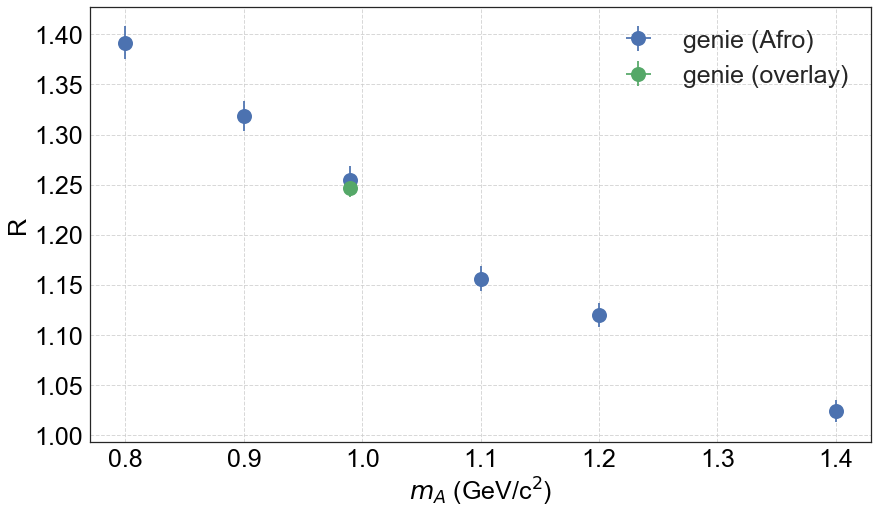

In [13]:
# CC1p0pi = dict({'mA=0.99':geni})
observable_low_high_ratio(var='Q2',debug=0
                          ,mA_array=mA_array
                          ,xmin_bins=Q2min_bins,xmax_bins=Q2max_bins)

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
for i_mA,(mA,color) in enumerate(zip(mA_array
                                     ,['red','blue','green','black','purple','orange','cyan'])):
    sample = genie_CC1p0pi[mA]
    h,bins=np.histogram( sample['Q2'] , bins=np.linspace(0.,1.,25));
    mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(bins[1]-bins[0])
    h = 100*h*(1./np.sum(h))
    plt.errorbar(x=mid , y=h , xerr=bin_width
                 ,fmt='.',markersize=0,label=r'$m_A = %.2f$ GeV/c$^2$'%mA,capthick=2)
    plt.plot([Q2min_bins[0],Q2min_bins[0]],ax.get_ylim(),'--'
         ,[Q2min_bins[1],Q2min_bins[1]],ax.get_ylim(),'--'
         ,[Q2max_bins[1],Q2max_bins[1]],ax.get_ylim(),'--',color='black')

set_axes(ax,r'$Q^2$ (GeV/c)$^2$','frequency [%]',do_add_grid=True,do_add_legend=True)
plt.tight_layout()    